# Confidence Regions for Level Sets

A collection of explorations and results about the method to draw confidence regions for the levels sets of the survival function using Mammen and Polonik's method, and extrapolating these regions into distribution's tails using Cooley's method.

## How does this differ from Take 1?

1. We're using the `sf` and `sfheaders` packages to convert the confidence regions from sets of points on a grid to polygons that make area and containment calculations easier/less tedious to deal with from a software/coding perspective.

2. We're implementing a new data-adaptive approach to selecting $\beta_{n}$, using various procedures. Each procedure will be detailed below, and relevant results will be provided.

In [10]:
library(mvtnorm)
library(ks)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(ismev)
library(repr)
library(sf)
library(sfheaders)

In [11]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/bases_betachoice/'

## Setup for Bound Optimization

In Mammen and Polonik's paper, they reduce the problem of trying to find confidence regions for the isolines of interest to finding sets $\hat{C}_{\ell}$ and $\hat{C}_{u}$ such that $\hat{C}_{\ell} \subset C^{-} \text{ and } C \subset \hat{C}_{u}$, where:

+ $\hat{C}_{u} = \left\{x \in \mathbb{R}^{2} : \hat{f}_{n}(x) \geq p - \hat{b}_{n} \right\}$
+ $\hat{C}_{\ell} = \left\{x \in \mathbb{R}^{2} : \hat{f}_{n}(x) > p + \hat{b}_{n} \right\}$
+ $C = \left\{ x \in \mathbb{R}^{2} : f(x) \geq p \right\}$
+ $C^{-} = \left\{ x \in \mathbb{R}^{2} : f(x) > p \right\}$
+ $f(x) = f((x_{1}, x_{2})) = \mathbb{P}(X_{1} \geq x_{1}, X_{2} \geq x_{2})$, estimated by $\hat{f}_{n}$

Mammen and Polonik derive the following non-asymptotic sandwich bound on the true coverage rate:

$$(1-\alpha) - \mathbb{P}(A_{n}^{c}) + (p_{n} - F_{Z_{n}}(b_{n}^{+})) \leq \mathbb{P}\left[ \hat{C}_{\ell} \subset C^{-} \text{ and } C \subset \hat{C}_{u} \right] \leq (1-\alpha) + (p_{n0} - F_{Z_{n}}(b_{n}^{-}))$$,

where:

+ $A_{n} = \left\{ \sup_{x \in \mathbb{R}^{2}} \lvert \hat{f}_{n}(x) - f(x) \rvert \leq \beta \right\}$
+ $p_{n} = \mathbb{P}\left[ Z_{n}(\beta) \leq \hat{b}_{n} \right]$
+ $F_{Z_{n}}(b_{n}^{+}) = \mathbb{P}\left[ Z_{n}(\beta) \leq b_{n}^{+} \right]$
+ $p_{n0} = \mathbb{P}\left[ Z_{n}(0) \leq \hat{b}_{n} \right]$
+ $F_{Z_{n}}(b_{n}^{-}) = \mathbb{P}\left[ Z_{n}(\beta) \leq b_{n}^{-} \right]$

and:

+ $\hat{b}_{n} = 1 - \alpha \text{ quantile of } Z_{n}(\beta)$
+ $Z_{n}(\beta) = \sup_{x \in \mathbb{R}^{2}: \lvert f(x) - p \rvert \leq \beta} \lvert \hat{f}_{n}(x) - f(x) \rvert$
+ $b_{n}^{-} = \inf\{t: F_{Z_{n}}(t) \geq 1 - \alpha \}$
+ $b_{n}^{+} = \sup\{t : F_{Z_{n}}(t) \leq 1 - \alpha \}$

Using this problem setup, we attempt to choose $\beta$ such that estimates of either the upper bound is low or the lower bound is high (or both)


## Method Table of Contents

1. Minimizing upper bound with respect to $\beta$
2. Smallest $\beta$ such that lower bound $\geq 1 - \alpha$

## Methods

### 1. Minimizing upper bound with respect to $\beta$ (subject to being $\geq 1 - \alpha$)

This seems like a promising method, given the plots in `beta_exploration.ipynb`. $\beta$ chosen from minimizing with lower bound still greater than $1-\alpha$ seems way too loose ($\beta$ is larger than values known to have 100% coverage from previous explorations).

#### Attempt 1a: `optimize`

##### Specifications:
+ $\beta_{0} = 1 \times 10^{-5}$
+ `optim` to minimize the upper bound padding, over interval $[\beta_{0}, 0.01]$
+ `optim` tolerance: $0.001$


In [12]:
# load up the base files to get base coverages

all_folders <- list.files(path=path)
specifiers <- c('upperoptim', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

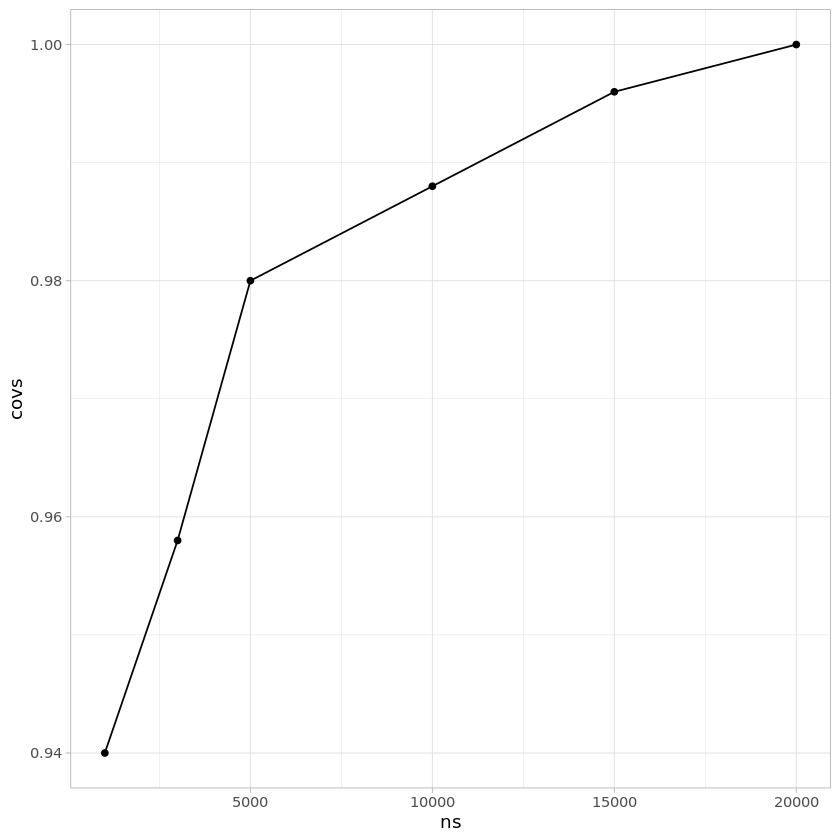

In [13]:
cvg_res <- data.frame(ns, covs)
ggplot(cvg_res) + geom_line(aes(x = ns, y = covs)) + geom_point(aes(x = ns, y = covs)) + theme_light()

Plotting the distribution of $\beta$ for both covers and failure to covers

In [14]:
n5000_res <- data.frame(as.vector(betas), as.vector(is_covered))

In [15]:
plt_df <- data.frame(as.vector(beta), as.vector(is_covered))
colnames(plt_df) <- c('beta', 'cover')

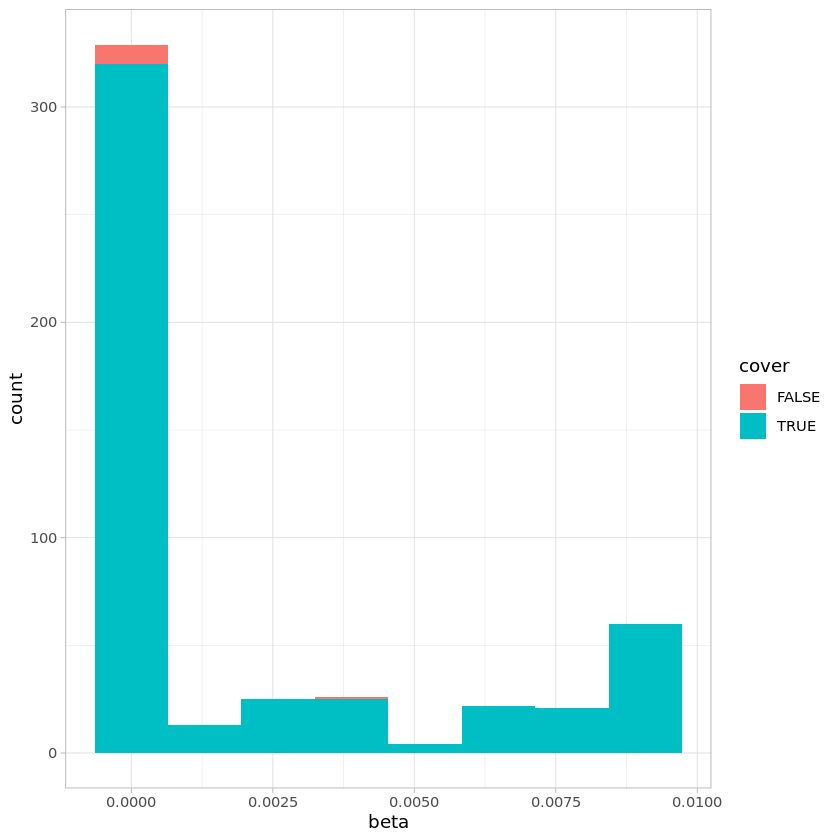

In [16]:
ggplot(plt_df) + geom_histogram(aes(x = beta, fill = cover), bins = 8) + theme_light()

For $n = 5000$, we observe overcoverage already (coverage rate about 0.98). Seems like most of the failure to covers, which we would need more of proportionally in order to remedy this overcoverage, is with smaller $\beta$. This is also the predominant $\beta$, so it must be that the other $\beta$ we settle on are these local minima I identified when using `optim`. What if we just took the small $\beta$, what proportion of those would cover?

In [17]:
plt_df %>% filter(beta < 0.00125) %>% select(cover) %>% summarize(mean(cover))

mean(cover)
<dbl>
0.972973


Coverage shrinks closer to the nominal coverage, which is good. Still a bit overcovered, but we can work with this (maybe more simulations would help?) Anyway, it seems that the method actually does a pretty good job at addressing the overcoverage, just have to make sure that the $\beta$ you settle on is not some local minimum of the upper bound padding, as it may be with the higher $\beta$

##### Conclusions
+ Seems to address overcoverage pretty well, although definitely does not converge to nominal coverage as $n$ gets larger (gets closer to coverage with certainty)
+ Too many covers might be due to $\beta$ sometimes being inordinately high. This could be due to `optim` finding some local minima 'kinks' in the objective function of $\beta$. May some other method that doesn't rely on optimization (zeros based method, etc.)

#### Attempt 1b: Using a line-search

In [18]:
all_folders <- list.files(path=path)
specifiers <- c('upperlinesearch', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

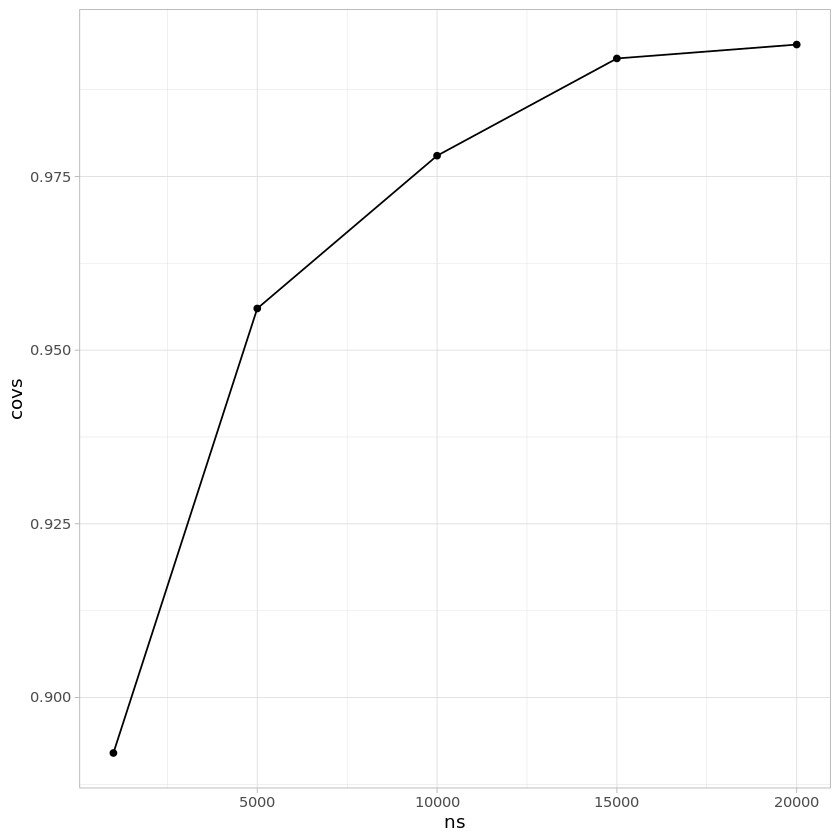

In [19]:
cvg_res <- data.frame(ns, covs)
ggplot(cvg_res) + geom_line(aes(x = ns, y = covs)) + geom_point(aes(x = ns, y = covs)) + theme_light()

In [20]:
cvg_res

ns,covs
<dbl>,<dbl>
10000,0.978
1000,0.892
15000,0.992
20000,0.994
5000,0.956


#### Attempt 1c: Using a root finding algorithm

## Supplement: Exploring Properties of Bounds in Real-World (i.e. not bootstrap world)

Not sure if the weird behavior of the bounds in the bootstrap world is just due to a mismatch between the bootstrap and real worlds, so assuming infinite samples from a known distribution, I'm going to see what all this looks like in the real world!

### 1. Looking at Upper Bound Specifically

POTENTIAL DIRECTION TO TRY: I wonder if doing a smooth bootstrap over here will magically solve my problems? At least going to look at the effect of smooth vs. nonparametric bootstrap in the Take 3 set..